# DATA

Source of the data: 
https://www.kaggle.com/code/surekharamireddy/covid-19-rorschach-test-dataset/

Straight away, the dataset was used for a study about the evolution of Rorschach protocols before and after the Pandemic: "Perform between-subject statistical analysis (covariance & clustering) of all the sample variables, to detect changes between pre and post pandemic responses to the Rorschach test."

Some important information about the data: 

    User : User Id number
    PQlevel : Professional qualifications levels are based on the
    Clinet : Client Id number
    Age : Client age in Years
    Gender : Client Gender
    Country : Client Country
    Protocol : Protocol Id Number
    Test Date : The Date the RAP3 protocol was created
    R : The total number of the responses associated with the protocol
    ResponseOrder : The order of responses in the protocol
    CardId : Rorschach cardnumber 1 to 10
    Location : Indicated to which area of the blot the responses referred to
    LocationNumber : The location Normative Number
    Developmental Quality : The quality of processing that has been involved in the formation of the responses
    Determinants : All the visual stimulli in the blot that shaped the reported objects in the response .
    Pair : Two identical objects are reported , based on the symmetry of the blot
    Form Quality : Indicates how good is the fitness between the area of blot being used and the form requirements of the object specified in the response
    FQtext : The form quality associated Normative Text
    Contents : Content Coding is consisting of abbrevations for the category to which the responded object Belongs
    Popular : Responses that occur with a high frequency with a normative sample .
    ZCode : ZCode is coded in responses that involve organizational activity of relationships between distinct blot areas .
    ZScore : A Numerical value assigned to responses in which such Organizational activity occurs .
    Special Scores : Indicate the presence of special features in the response
    Rejection : The number of card rejections in the Protocol .


# Data exploration and cleaning

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [328]:
data = pd.read_csv(r"rap_dataset.tsv", sep = "\t")

In [329]:
data.isna().sum()

User                         0
PQLevel                      0
Client                       0
Age                          0
Gender                       0
Country                      0
Protocol                     0
TestDate                     0
R                            0
ResponseOrder                0
cardID                       0
Location                     0
LocationNumber          119435
DevelopmentalQuality         0
Determinants                 0
Pair                         0
FormQuality                  0
FQText                  442103
Contents                     0
Popular                      0
ZCode                   238068
ZScore                  238069
SpecialScores           298146
Rejection                    0
dtype: int64

In [330]:
df = data.dropna()

In [331]:
df.columns

Index(['User', 'PQLevel', 'Client', 'Age', 'Gender', 'Country', 'Protocol',
       'TestDate', 'R', 'ResponseOrder', 'cardID', 'Location',
       'LocationNumber', 'DevelopmentalQuality', 'Determinants', 'Pair',
       'FormQuality', 'FQText', 'Contents', 'Popular', 'ZCode', 'ZScore',
       'SpecialScores', 'Rejection'],
      dtype='object')

In [332]:
df.shape

(14351, 24)

For the initial 2 models the aim is to get a model for the determinants and the content labels

Possible Content labels

In [333]:
labels = df[['Contents']]

In [334]:
len(df['Contents'].unique())

1029

The explanation for the amount of labels is that there are different possible combinations of labels and they appear all together the the columns.

In [335]:
counts = pd.DataFrame(labels.value_counts(), columns=["count"])
counts = counts[counts["count"] < 10]
counts

,count
Contents,
"H,Cg,Ay",9
"(H),Sx",9
"Hh,A",9
"Hd,Na",9
Ex,9
...,...
"H,A,Art",1
"A,Bl,An",1
"A,Ay,Ls",1


In [336]:
df['Contents'].iloc[30:50]

439          (H)
441            A
447         A,Id
452            A
458            A
466      (Hd),Fi
468           Ad
469         H,Cg
481            H
498           Bt
500     H,Art,Ls
791         H,Cg
792          (H)
800          (H)
1309        H,Id
1314       Art,H
1318        H,Cg
1322     (Hd),Ay
1327          An
1373        H,Cg
Name: Contents, dtype: object

And that is the case for the determinants as well.

In [337]:
df[["Determinants"]]

,Determinants
121,Ma
129,Mp
130,"Ma,FC"
144,F
155,"Mp,Fr"
...,...
506392,"Fr,FMp"
506395,FT
506398,"FV,FMa"
506451,"FD,CF"


MULTILABEL CLASSIFICATION

If we were to leave the labels as they are, the models would be predicting the whole string corresponding to the data instead of the label. To model this problem, I will make dummy variables for each possible label

In [338]:
labels = df[["Determinants"]]

In [339]:
labels_contents = df[["Contents"]]

Exploring the determinant labels

Since the determinants columns can contain multiple determinant values for each entry, I will get dummy variables. 

In [340]:
labels = labels.apply(lambda labels: [x.split(",") for x in labels])
labels_determinants = labels['Determinants'].str.join('|').str.get_dummies()

In [341]:
labels_determinants

,C,C',C'F,CF,Cn,F,FC,FC',FD,FMa,...,T,TF,V,VF,Y,YF,ma,ma-p,mp,rF
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
506395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
506398,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
506451,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [342]:
agg_dict_determinants = {}
total = 0
for label in labels_determinants.columns:
    total_label = sum(labels_determinants[label])
    total = total + total_label
    agg_dict_determinants[label] = total_label
agg_dict_determinants["total"] = total
agg_dict_determinants

{'C': 159,
 "C'": 88,
 "C'F": 226,
 'CF': 588,
 'Cn': 23,
 'F': 4859,
 'FC': 1033,
 "FC'": 1060,
 'FD': 922,
 'FMa': 1161,
 'FMa-p': 26,
 'FMp': 497,
 'FT': 314,
 'FV': 217,
 'FY': 457,
 'Fr': 321,
 'Ma': 3378,
 'Ma-p': 76,
 'Mp': 2118,
 'T': 39,
 'TF': 100,
 'V': 16,
 'VF': 65,
 'Y': 35,
 'YF': 118,
 'ma': 343,
 'ma-p': 9,
 'mp': 321,
 'rF': 35,
 'total': 18604}

As we can see, there are certain labels that appear in a proportion of around 20-40/18604. This niche cases may cause problems in the future but for now I'll focus on making the baseline models for the POC. Also, it seems like the "ma, ma-p and mp" determinants are repeated in upper and lowercase.

In [343]:
# actual count for the labels in the dataset

for col in labels_determinants:
    lower_case_col = str(col).lower()
    if lower_case_col in labels_determinants.columns:
        labels_determinants[col] = labels_determinants[col] + labels_determinants[lower_case_col]
        del labels_determinants[lower_case_col]

# to check the sum was done correctly
agg_dict_determinants = {}
total = 0
for label in labels_determinants.columns:
    total_label = sum(labels_determinants[label])
    total = total + total_label
    agg_dict_determinants[label] = total_label
agg_dict_determinants["total"] = total
agg_dict_determinants

{'C': 159,
 "C'": 88,
 "C'F": 226,
 'CF': 588,
 'Cn': 23,
 'F': 4859,
 'FC': 1033,
 "FC'": 1060,
 'FD': 922,
 'FMa': 1161,
 'FMa-p': 26,
 'FMp': 497,
 'FT': 314,
 'FV': 217,
 'FY': 457,
 'Fr': 321,
 'Ma': 3721,
 'Ma-p': 85,
 'Mp': 2439,
 'T': 39,
 'TF': 100,
 'V': 16,
 'VF': 65,
 'Y': 35,
 'YF': 118,
 'rF': 35,
 'total': 18604}

In [344]:
list_dets = []
for k, v in agg_dict_determinants.items():
    list_dets.append(k)

In [345]:
print(list_dets)

['C', "C'", "C'F", 'CF', 'Cn', 'F', 'FC', "FC'", 'FD', 'FMa', 'FMa-p', 'FMp', 'FT', 'FV', 'FY', 'Fr', 'Ma', 'Ma-p', 'Mp', 'T', 'TF', 'V', 'VF', 'Y', 'YF', 'rF', 'total']


Now we can see the actual distribution of the labels in the data!

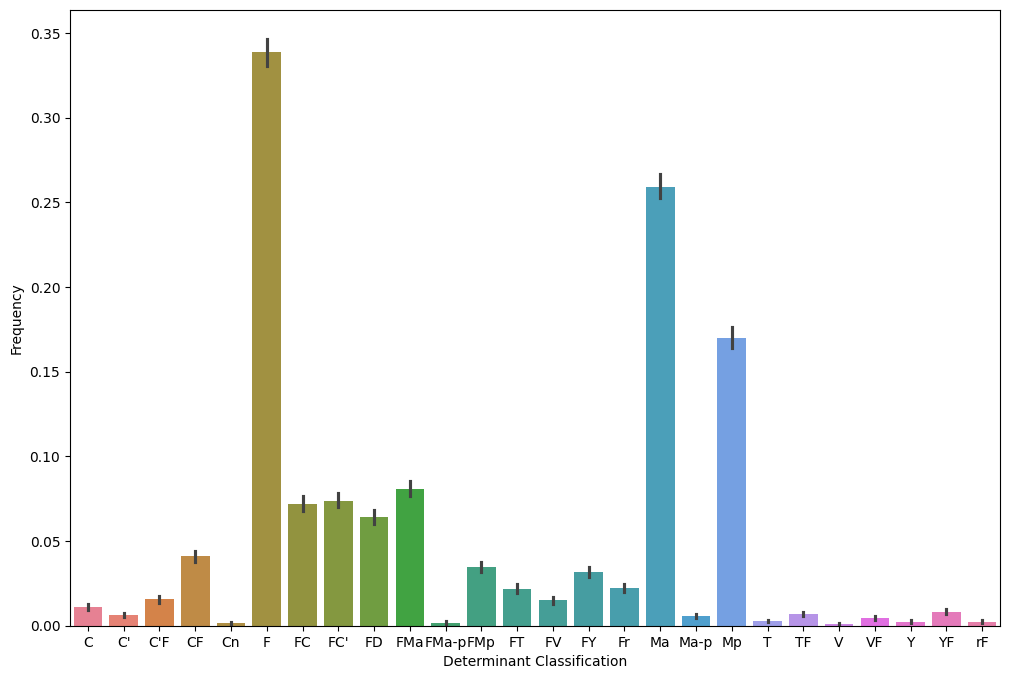

In [346]:
# distribution of the labels

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=labels_determinants)
ax.set_xlabel("Determinant Classification")
ax.set_ylabel("Frequency")
plt.show()

In [347]:
# looking at the common values for these more niche determinants
# cutoff = 0.05 * 

list_niche_dets = [key for key, value in agg_dict_determinants.items() if value < 50]

for det in list_niche_dets:
    example_values = pd.DataFrame(df[df["Determinants"].str.contains(det)]["FQText"].value_counts())
    print("Determinant: ",det, example_values, "\n")

Determinant:  Cn                                                     count
FQText                                                   
Insect                                                  4
Art (Abstract)                                          3
Humans or Human-Like Figures (As D1 in a scene ...      2
Animals (Unspecified)                                   2
Animals (Two, unspecified)                              1
Humans (Two with D7 as separate object)                 1
Head (Animal)                                           1
Face (Human or animal)                                  1
Boat (With sails, front view)                           1
Animal(s)                                               1
Animal (Four legged, and appropriate to contour...      1
Body                                                    1
Pelvis                                                  1
Walkway (As center space and other areas as flo...      1
Anatomy                                                

As we can see some responses seem to be repeated for different determinant labels but that could be due to various labels usually appearing together

In [348]:
list_niche_dets

['Cn', 'FMa-p', 'T', 'V', 'Y', 'rF']

In [349]:
deter_counts_composed = df["Determinants"].isin(list_niche_dets)
df[deter_counts_composed]



,User,PQLevel,Client,Age,Gender,Country,Protocol,TestDate,R,ResponseOrder,...,Determinants,Pair,FormQuality,FQText,Contents,Popular,ZCode,ZScore,SpecialScores,Rejection
7115,1042,C,36034,58,Male,Slovenia,36935,11/15/2017 5:34,24,13,...,FMa-p,1,o,"Animal (Small, with D5 as ear, and Dd21 as tai...",A,0,ZD,3.0,"AG,FAB,PHR",0
105783,11678,C,56392,34,Male,Israel,57536,5/10/2020 4:19,18,5,...,FMa-p,1,u,Duck,A,0,ZA,3.0,"COP,GHR",0
130425,13430,C,31387,23,Female,United States (USA),32152,4/9/2017 9:10,14,9,...,rF,0,u,"Heads (Human, profile, back to back)",Hd,0,ZA,2.5,PHR,0
145023,14206,C,54118,35,Female,Israel,55234,1/9/2020 4:01,20,15,...,FMa-p,1,u,Iguana,"A,Bt",0,ZD,3.0,INC,0
231974,18038,C,32786,47,Male,Slovenia,33649,6/5/2017 11:28,36,25,...,FMa-p,1,-,"Animals (Two, real, with each as one half of t...",A,0,ZW,2.5,"COP,AG,PHR,ALOG",0
247165,18492,C,50928,40,Female,Canada,52018,8/23/2019 21:02,20,8,...,FMa-p,1,o,Animal,A,0,ZA,4.0,PSV,0
257082,18744,C,31557,17,Female,India,32337,4/17/2017 12:50,47,40,...,FMa-p,1,u,Head (Animal),"Ad,A",0,ZA,2.5,ALOG,0
341905,21428,B,36646,26,Female,Norway,37554,12/8/2017 15:10,23,21,...,rF,0,-,Face,(Hd),0,ZD,4.5,PHR,0
394245,23362,C,41293,8,Female,United States (USA),42280,6/16/2018 23:29,20,15,...,rF,0,u,Flag,"Ay,A",1,ZW,4.5,PER,0
409394,24182,C,43230,45,Male,Finland,44231,9/25/2018 5:40,18,10,...,rF,0,o,Island(s),"Fi,Ls",0,ZW,2.5,MOR,0


From the underrepresented determinants, FMA-p and rf are the only ones that show up on their own, it is safe to assume the other determinants appear alongside others.

In [350]:
df[df["Determinants"].str.contains(",T")]

,User,PQLevel,Client,Age,Gender,Country,Protocol,TestDate,R,ResponseOrder,...,Determinants,Pair,FormQuality,FQText,Contents,Popular,ZCode,ZScore,SpecialScores,Rejection
30966,3468,C,47957,48,Female,United States (USA),49022,4/21/2019 18:14,12,9,...,"Ma,TF",1,o,Humans (Two),"Hd,Cl,Cg",1,ZW,2.5,GHR,0
47837,5998,C,35855,13,Female,United States (USA),36753,11/8/2017 20:23,14,14,...,"CF,TF,FD",0,-,Face,"Hd,Cg",0,ZS,6.0,"ALOG,PHR",0
51425,6872,C,57084,100,Not Specified,Czech Republic,58231,6/23/2020 4:58,9,9,...,"Mp,FD,TF",0,o,Giant,"H,Cg",1,ZW,2.0,GHR,0
66444,9020,C,33199,25,Female,Afghanistan,34070,6/20/2017 13:33,19,8,...,"VF,FD,TF,FC'",0,-,Mountain,"Ay,Ls",0,ZW,2.5,"DR,ALOG",0
67183,9092,C,43211,38,Female,Philippines,44212,9/24/2018 1:49,46,20,...,"F,TF",0,o,Bone (Skeletal),An,0,ZD,3.5,AB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496648,28720,C,55284,27,Male,Philippines,56537,3/4/2020 21:45,16,12,...,"F,CF,FMa,TF",1,-,Animal,A,1,ZW,4.5,PER,0
496649,28720,C,55284,27,Male,Philippines,56537,3/4/2020 21:45,16,13,...,"FD,rF,mp,TF",0,u,Face (Monster),(Hd),0,ZW,5.5,"AB,PHR,PER",0
496651,28720,C,55284,27,Male,Philippines,56537,3/4/2020 21:45,16,15,...,"FD,CF,FMp,TF",1,-,Animal,Ad,0,ZA,4.0,PER,0
496652,28720,C,55284,27,Male,Philippines,56537,3/4/2020 21:45,16,16,...,"FD,CF,FMp,TF",1,-,Animal,Ad,0,ZA,4.0,PER,0


Since there is so little data with just those labels, we may have to delete them altogether and aim for a more basic model.

However, it is still crucial to check the reliability of the data. I will look at cardID as well in case there are two determinant annotations  for the same answer in the same card.

In [351]:
# df[["FQText", "Determinants", "cardID"]].value_counts().sort_index()

In [352]:
card_ids_dets = df[["FQText", "Determinants", "cardID"]]
group = card_ids_dets.groupby(["FQText", "Determinants", "cardID"]).agg({"FQText" : ["count"]})
group

FQText
                                         count
FQText              Determinants cardID       
Abstract            F            7           2
                    Fr           7           1
                    Mp           1           1
                                 7           1
Abstract Drawing    F            6           1
...                                        ...
X-ray (Unspecified) F            6           1
                    FC'          3           2
                                 6           1
                    FT,C'        3           1
                    FY           7           1

[5561 rows x 1 columns]

In [353]:
# Looking at the entries that have the same text and cardID

duplicate = df.duplicated(subset=["FQText", "cardID"])
df_same_response_same_card_diff_determinant = df[duplicate]
df_same_response_same_card_diff_determinant[["FQText","cardID", "Determinants", "Contents"]].sort_values("FQText")

,FQText,cardID,Determinants,Contents
398851,Abstract,7,Mp,"Hd,Hx"
259663,Abstract,7,Fr,"Art,A"
203209,Abstract,7,F,"Art,H"
401257,Abstract Drawing,6,"FMa,FD","Ad,A,Hd"
374178,Abstract Drawing,6,ma,Hx
...,...,...,...,...
473568,X-ray (Specific),6,"FD,C'F","Xy,Hd"
280932,X-ray (Unspecified),3,FC',"Hd,H"
145050,X-ray (Unspecified),3,FC',"Art,An"
145034,X-ray (Unspecified),3,"FT,C'","Xy,Hd"


We can also tell that we have the same issue with some of the Contents labels.

Unfortunately, we can see that there are responses that have been annotated inconsistently. Ideally we would consult a psychologist or try to validate the dataset but for the sake of having a POC up and running, I will drop the second instance of the data points that have the same FQText and cardID

In [354]:
df.shape

(14351, 24)

In [355]:
df_1 = df.drop_duplicates(subset=["FQText","cardID"], keep="first")
df_1.shape

(1236, 24)

In [356]:
# if we dropped all the double texts not taking into account cardID

# we are feeding df2 to everything

df_2 = df.sort_values("PQLevel", ascending=False).drop_duplicates(subset=["FQText"], keep="first")
df_2.shape

(747, 24)

We have dropped a lot of data points which is not ideal. Moreover, it may be helpful to use the cardID as a feature as we can see it is relevant by the amount of text whose label varies according to it. At a first glance, it seems obvious that the models we trained won't have satisfactory results given the low quality of the data but we'll proceed just to make a POC.

Exploring the content labels

In [357]:
labels_contents = df_2[["Contents"]]

In [358]:

labels_contents = labels_contents.apply(lambda labels: [x.split(",") for x in labels])
labels_contents = labels_contents['Contents'].str.join('|').str.get_dummies()


In [359]:
labels_contents

,(A),(Ad),(H),(Hd),A,Ad,An,Art,Ay,Bl,...,H,Hd,Hh,Hx,Id,Ls,Na,Sc,Sx,Xy
121,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
313400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
313749,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313760,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258760,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
440801,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324198,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [360]:
agg_dict_contents = {}
total = 0
for label in labels_contents.columns:
    total_label = sum(labels_contents[label])
    total = total + total_label
    agg_dict_contents[label] = total_label
agg_dict_contents["total"] = total
agg_dict_contents.keys()

dict_keys(['(A)', '(Ad)', '(H)', '(Hd)', 'A', 'Ad', 'An', 'Art', 'Ay', 'Bl', 'Bt', 'Cg', 'Cl', 'Ex', 'Fd', 'Fi', 'Ge', 'H', 'Hd', 'Hh', 'Hx', 'Id', 'Ls', 'Na', 'Sc', 'Sx', 'Xy', 'total'])

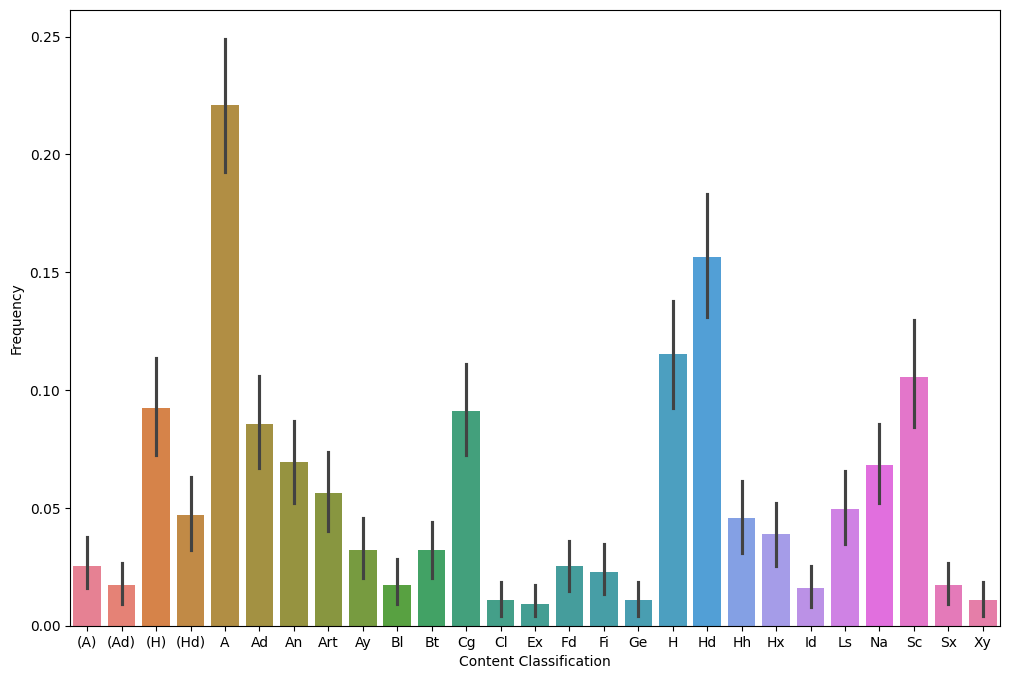

In [361]:
# distribution of the labels

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=labels_contents)
ax.set_xlabel("Content Classification")
ax.set_ylabel("Frequency")
plt.show()

The low proportion of edge cases doesn't seem to be that much of a problem when speaking about content labels

# Model development

So far, we have been looking at the labels for the whole dataset but since we dropped a lot of inconsistent entries we should have a look at the labels proportion again.

In [362]:
labels_contents = df_2[["Contents"]]
labels_determinants = df_2[["Determinants"]]

labels_determinants = labels_determinants.apply(lambda labels: [x.split(",") for x in labels])
y_determinants = labels_determinants['Determinants'].str.join('|').str.get_dummies()

# merging the repeated labels
for col in y_determinants:
    lower_case_col = str(col).lower()
    if lower_case_col in y_determinants.columns: 
        y_determinants[col] = y_determinants[col] + y_determinants[lower_case_col].where(((y_determinants[col] == 0 ) & (y_determinants[lower_case_col] != 0)) | ((y_determinants[col] != 0 ) & (y_determinants[lower_case_col] == 0))) 
        # y_determinants[col] = y_determinants[col] + y_determinants[lower_case_col]
        del y_determinants[lower_case_col]
y_determinants = y_determinants.fillna(0)

# print(np.unique(y_determinants))

labels_contents = labels_contents.apply(lambda labels: [x.split(",") for x in labels])
y_contents = labels_contents['Contents'].str.join('|').str.get_dummies()

In [363]:
y_contents = y_contents.astype("int")
y_determinants = y_determinants.astype("int")

In [364]:
np.unique(y_determinants)

array([0, 1])

In [365]:
np.unique(y_contents)

array([0, 1])

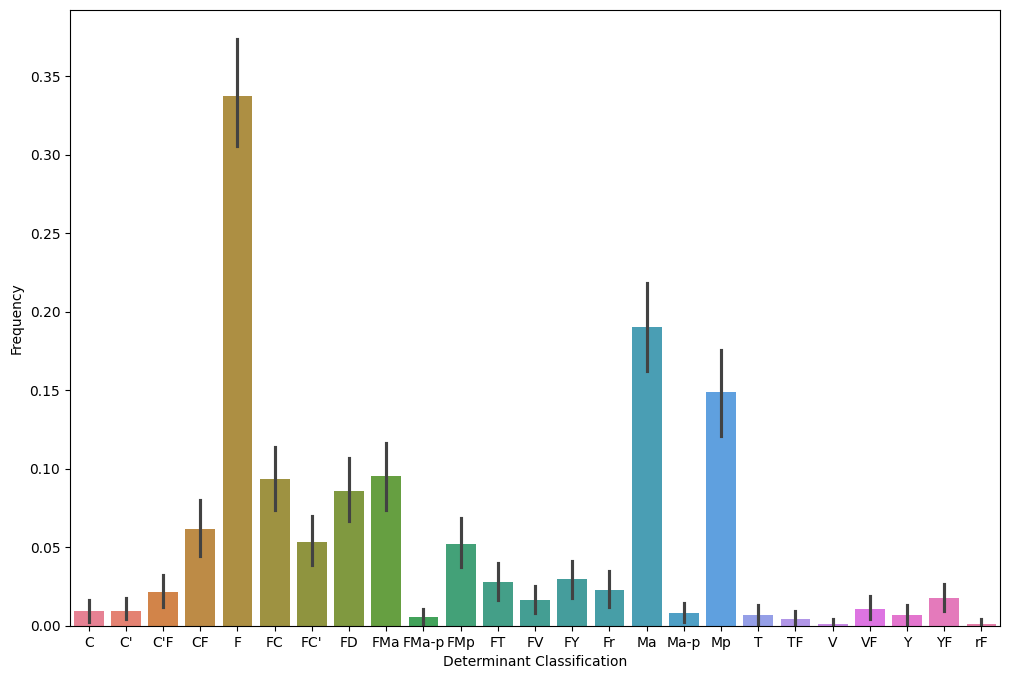

In [366]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data = y_determinants)
ax.set_xlabel("Determinant Classification")
ax.set_ylabel("Frequency")
plt.show()

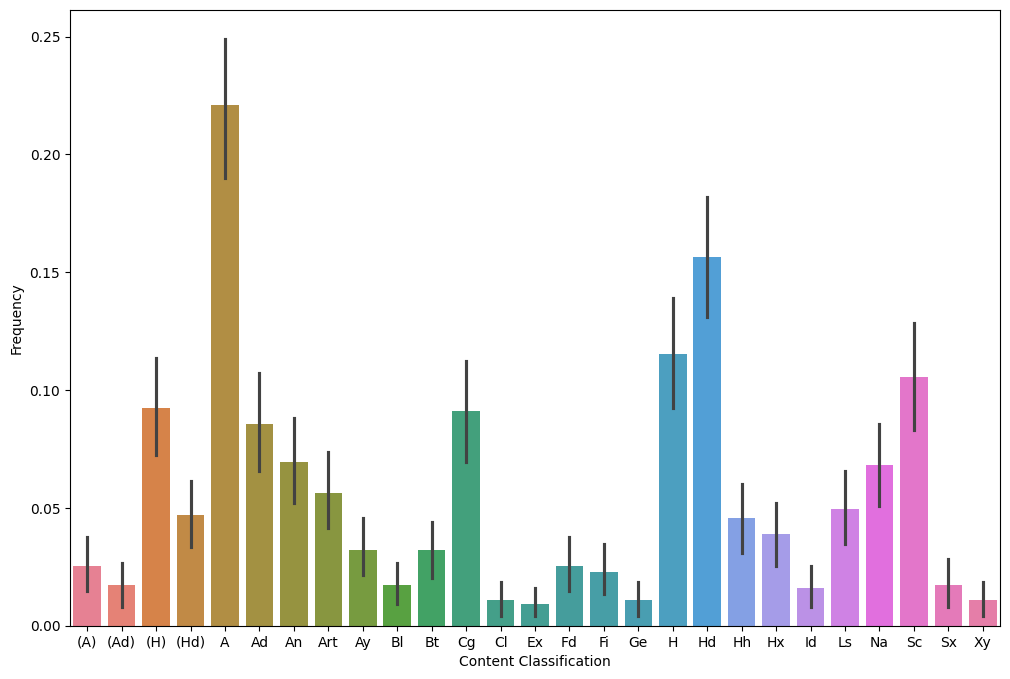

In [367]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data = y_contents)
ax.set_xlabel("Content Classification")
ax.set_ylabel("Frequency")
plt.show()

In [368]:
agg_dict_contents = {}
total = 0
for label in y_contents.columns:
    total_label = sum(y_contents[label])
    total = total + total_label
    agg_dict_contents[label] = total_label
agg_dict_contents["total"] = total
agg_dict_contents

{'(A)': 19,
 '(Ad)': 13,
 '(H)': 69,
 '(Hd)': 35,
 'A': 165,
 'Ad': 64,
 'An': 52,
 'Art': 42,
 'Ay': 24,
 'Bl': 13,
 'Bt': 24,
 'Cg': 68,
 'Cl': 8,
 'Ex': 7,
 'Fd': 19,
 'Fi': 17,
 'Ge': 8,
 'H': 86,
 'Hd': 117,
 'Hh': 34,
 'Hx': 29,
 'Id': 12,
 'Ls': 37,
 'Na': 51,
 'Sc': 79,
 'Sx': 13,
 'Xy': 8,
 'total': 1113}

In [369]:
agg_dict_contents = {}
total = 0
for label in y_determinants.columns:
    total_label = sum(y_determinants[label])
    total = total + total_label
    agg_dict_contents[label] = total_label
agg_dict_contents["total"] = total
agg_dict_contents

{'C': 7,
 "C'": 7,
 "C'F": 16,
 'CF': 46,
 'F': 252,
 'FC': 70,
 "FC'": 40,
 'FD': 64,
 'FMa': 71,
 'FMa-p': 4,
 'FMp': 39,
 'FT': 21,
 'FV': 12,
 'FY': 22,
 'Fr': 17,
 'Ma': 142,
 'Ma-p': 6,
 'Mp': 111,
 'T': 5,
 'TF': 3,
 'V': 1,
 'VF': 8,
 'Y': 5,
 'YF': 13,
 'rF': 1,
 'total': 983}

As we can see, there are many labels for which the number of samples us really small.

Since the names of the columns for the binary content / determinant labels are not intuitive at all, I'll save the columns in new variables. That way we will be able to get our y by indexing by the list of columns.

In [370]:
cols_determinants = list(labels_determinants.columns)
cols_contents = list(labels_contents.columns)

Merging the labels back to the main df to create our dataset with the dummies

In [371]:
dfs = [df_2.drop(["Contents", "Determinants"], axis=1), y_contents, y_determinants]
data = pd.concat(dfs, axis = 1)
data

,User,PQLevel,Client,Age,Gender,Country,Protocol,TestDate,R,ResponseOrder,...,Ma,Ma-p,Mp,T,TF,V,VF,Y,YF,rF
121,272,C,40624,10,Male,Chile,41595,5/22/2018 14:27,15,1,...,1,0,0,0,0,0,0,0,0,0
313396,20436,C,34937,21,Not Specified,United States (USA),35822,9/29/2017 4:08,17,9,...,1,0,0,0,0,0,0,0,0,0
313400,20436,C,34937,21,Not Specified,United States (USA),35822,9/29/2017 4:08,17,13,...,0,0,0,0,0,0,0,0,0,0
313749,20464,C,34983,30,Male,United States (USA),35871,10/2/2017 20:20,61,6,...,0,0,0,0,0,0,0,0,0,0
313760,20464,C,34983,30,Male,United States (USA),35871,10/2/2017 20:20,61,17,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433526,25114,B,45405,27,Male,Lebanon,46441,12/29/2018 15:54,22,20,...,1,0,0,0,0,0,0,0,0,0
258760,18780,B,31482,23,Female,Liberia,32256,4/13/2017 14:39,18,7,...,0,1,0,0,0,0,0,0,0,0
440801,25472,B,48473,97,Not Specified,United States (USA),49541,5/12/2019 21:54,20,1,...,0,0,0,0,0,0,0,0,0,0
324198,20670,B,36511,42,Female,United States (USA),37419,12/3/2017 18:21,21,9,...,0,0,0,0,0,0,0,0,0,0


In [372]:
df_2.columns

Index(['User', 'PQLevel', 'Client', 'Age', 'Gender', 'Country', 'Protocol',
       'TestDate', 'R', 'ResponseOrder', 'cardID', 'Location',
       'LocationNumber', 'DevelopmentalQuality', 'Determinants', 'Pair',
       'FormQuality', 'FQText', 'Contents', 'Popular', 'ZCode', 'ZScore',
       'SpecialScores', 'Rejection'],
      dtype='object')

In [373]:
data.columns

Index(['User', 'PQLevel', 'Client', 'Age', 'Gender', 'Country', 'Protocol',
       'TestDate', 'R', 'ResponseOrder', 'cardID', 'Location',
       'LocationNumber', 'DevelopmentalQuality', 'Pair', 'FormQuality',
       'FQText', 'Popular', 'ZCode', 'ZScore', 'SpecialScores', 'Rejection',
       '(A)', '(Ad)', '(H)', '(Hd)', 'A', 'Ad', 'An', 'Art', 'Ay', 'Bl', 'Bt',
       'Cg', 'Cl', 'Ex', 'Fd', 'Fi', 'Ge', 'H', 'Hd', 'Hh', 'Hx', 'Id', 'Ls',
       'Na', 'Sc', 'Sx', 'Xy', 'C', 'C'', 'C'F', 'CF', 'F', 'FC', 'FC'', 'FD',
       'FMa', 'FMa-p', 'FMp', 'FT', 'FV', 'FY', 'Fr', 'Ma', 'Ma-p', 'Mp', 'T',
       'TF', 'V', 'VF', 'Y', 'YF', 'rF'],
      dtype='object')

In [374]:
# dropping everything aside from the text and content/determinant labels

classification_data = data.drop(['User', 'PQLevel', 'Client', 'Age', 'Gender', 'Country', 'Protocol',
       'TestDate', 'R', 'ResponseOrder', 'cardID', 'Location',
       'LocationNumber', 'DevelopmentalQuality', 'Pair', 'FormQuality'
       , 'Popular', 'ZCode', 'ZScore', 'SpecialScores', 'Rejection',]
                                , axis = 1)


Using the clean entries

In [375]:
# classification_data = classification_data.drop_duplicates(subset=["FQText"], keep="first")

In [376]:
# final text-content df 

classification_data

,FQText,(A),(Ad),(H),(Hd),A,Ad,An,Art,Ay,...,Ma,Ma-p,Mp,T,TF,V,VF,Y,YF,rF
121,Animal (Winged but unspecified),0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
313396,Tree,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
313400,Lobster and Seaweed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313749,Eyes (Abstract),0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313760,Humans or Human-Like Figures (As D1 in a scene...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433526,Bud (Flower),0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
258760,Breasts,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
440801,Clouds,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324198,Ballerina (In costume),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Multilabel-classification Models

In [377]:
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [378]:
y_contents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 121 to 408890
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   (A)     747 non-null    int32
 1   (Ad)    747 non-null    int32
 2   (H)     747 non-null    int32
 3   (Hd)    747 non-null    int32
 4   A       747 non-null    int32
 5   Ad      747 non-null    int32
 6   An      747 non-null    int32
 7   Art     747 non-null    int32
 8   Ay      747 non-null    int32
 9   Bl      747 non-null    int32
 10  Bt      747 non-null    int32
 11  Cg      747 non-null    int32
 12  Cl      747 non-null    int32
 13  Ex      747 non-null    int32
 14  Fd      747 non-null    int32
 15  Fi      747 non-null    int32
 16  Ge      747 non-null    int32
 17  H       747 non-null    int32
 18  Hd      747 non-null    int32
 19  Hh      747 non-null    int32
 20  Hx      747 non-null    int32
 21  Id      747 non-null    int32
 22  Ls      747 non-null    int32
 23  Na      747 non

In [379]:
np.unique(y_contents)

array([0, 1])

In [380]:
y_contents.shape

(747, 27)

Model for Contents

In [381]:
X = classification_data["FQText"]
y = y_contents


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

models = [KNeighborsClassifier(), LogisticRegression(random_state=42, solver = "sag"), SVC(), RandomForestClassifier(random_state=42)]

for clf in models:

    pipeline = Pipeline([
                    ('text_tfidf', TfidfVectorizer(min_df = 2, max_df = 0.3, ngram_range = (1,3))),
                    ('clf', OneVsRestClassifier(clf))
                ])

    model = pipeline.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="micro")

    print(clf, accuracy, f1)

KNeighborsClassifier() 0.09333333333333334 0.13333333333333333
LogisticRegression(random_state=42, solver='sag') 0.02666666666666667 0.033898305084745756
SVC() 0.06666666666666667 0.10852713178294573


RandomForestClassifier(random_state=42) 0.05333333333333334 0.13793103448275862


In [382]:
list_labels = list(y_contents.columns)

class_report = classification_report(y_test, predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.33      0.17      0.22        12
           5       1.00      0.20      0.33         5
           6       0.50      0.40      0.44         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.50      0.11      0.18         9
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       1.00      0.25      0.40         4
          16       0.00      0.00      0.00         1
          17       0.17    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Looking at the classification report it is evident that the imbalanced dataset is causing problems

In [383]:
# pickle.dump(model, open(r"Models\Contents\pipeline_contents_One-Many_V2-07-04.sav", 'wb')) 

# will save the RF model since it was at the end of the list

Model for Determinants

Our models are not doing too good, maybe we could "cascade" the classifiers if the predictions of a previous classifier were good.
For example, computing content labels first and then using the content label prediction to inform the determinant prediction model
IFF one of the models was good 

In [384]:
data.columns

Index(['User', 'PQLevel', 'Client', 'Age', 'Gender', 'Country', 'Protocol',
       'TestDate', 'R', 'ResponseOrder', 'cardID', 'Location',
       'LocationNumber', 'DevelopmentalQuality', 'Pair', 'FormQuality',
       'FQText', 'Popular', 'ZCode', 'ZScore', 'SpecialScores', 'Rejection',
       '(A)', '(Ad)', '(H)', '(Hd)', 'A', 'Ad', 'An', 'Art', 'Ay', 'Bl', 'Bt',
       'Cg', 'Cl', 'Ex', 'Fd', 'Fi', 'Ge', 'H', 'Hd', 'Hh', 'Hx', 'Id', 'Ls',
       'Na', 'Sc', 'Sx', 'Xy', 'C', 'C'', 'C'F', 'CF', 'F', 'FC', 'FC'', 'FD',
       'FMa', 'FMa-p', 'FMp', 'FT', 'FV', 'FY', 'Fr', 'Ma', 'Ma-p', 'Mp', 'T',
       'TF', 'V', 'VF', 'Y', 'YF', 'rF'],
      dtype='object')

In [385]:
X

121                         Animal (Winged but unspecified)
313396                                                 Tree
313400                                  Lobster and Seaweed
313749                                      Eyes (Abstract)
313760    Humans or Human-Like Figures (As D1 in a scene...
                                ...                        
433526                                         Bud (Flower)
258760                                              Breasts
440801                                               Clouds
324198                               Ballerina (In costume)
408890                                             Antennae
Name: FQText, Length: 747, dtype: object

In [386]:
y_determinants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 121 to 408890
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   C       747 non-null    int32
 1   C'      747 non-null    int32
 2   C'F     747 non-null    int32
 3   CF      747 non-null    int32
 4   F       747 non-null    int32
 5   FC      747 non-null    int32
 6   FC'     747 non-null    int32
 7   FD      747 non-null    int32
 8   FMa     747 non-null    int32
 9   FMa-p   747 non-null    int32
 10  FMp     747 non-null    int32
 11  FT      747 non-null    int32
 12  FV      747 non-null    int32
 13  FY      747 non-null    int32
 14  Fr      747 non-null    int32
 15  Ma      747 non-null    int32
 16  Ma-p    747 non-null    int32
 17  Mp      747 non-null    int32
 18  T       747 non-null    int32
 19  TF      747 non-null    int32
 20  V       747 non-null    int32
 21  VF      747 non-null    int32
 22  Y       747 non-null    int32
 23  YF      747 non

In [387]:
np.unique(y_determinants)

array([0, 1])

In [388]:
y_determinants.shape

(747, 25)

In [389]:
y = y_determinants

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

models = [KNeighborsClassifier(), LogisticRegression(random_state=42, solver = "sag"), SVC(), RandomForestClassifier(random_state=42)]

for clf in models:

    pipeline = Pipeline([
                    ('text_tfidf', TfidfVectorizer(min_df = 2, max_df = 0.3, ngram_range = (1,3))),
                    ('clf', OneVsRestClassifier(clf))
                ])

    model = pipeline.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="micro")

    print(clf, accuracy, f1)


KNeighborsClassifier() 0.013333333333333334 0.019230769230769232


LogisticRegression(random_state=42, solver='sag') 0.013333333333333334 0.0


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SVC() 0.02666666666666667 0.03883495145631068
RandomForestClassifier(random_state=42) 0.05333333333333334 0.0847457627118644


In [390]:
class_report = classification_report(y_test, predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.27      0.09      0.13        35
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         0
          15       0.25      0.08      0.12        13
          16       0.00      0.00      0.00         1
          17       1.00    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Looking at the classification report it is evident that the imbalanced dataset is causing problems

In [391]:

pickle.dump(model, open(r"..\Models\Determinants\pipeline_determinants_One-Many_V2-07-04.sav", 'wb'))

# will save the RF model by default

# Function to get the predictions back from the classifier

In [392]:
y_determinants.columns

Index(['C', 'C'', 'C'F', 'CF', 'F', 'FC', 'FC'', 'FD', 'FMa', 'FMa-p', 'FMp',
       'FT', 'FV', 'FY', 'Fr', 'Ma', 'Ma-p', 'Mp', 'T', 'TF', 'V', 'VF', 'Y',
       'YF', 'rF'],
      dtype='object')

In [393]:
y_contents.columns

Index(['(A)', '(Ad)', '(H)', '(Hd)', 'A', 'Ad', 'An', 'Art', 'Ay', 'Bl', 'Bt',
       'Cg', 'Cl', 'Ex', 'Fd', 'Fi', 'Ge', 'H', 'Hd', 'Hh', 'Hx', 'Id', 'Ls',
       'Na', 'Sc', 'Sx', 'Xy'],
      dtype='object')

In [394]:
def evaluate_one_vs_rest(path, text):
    
    pipeline = pickle.load(open(path, "rb"))
    
    if "content" in path:
        # print("content found")
        possible_outcomes = ['(A)', '(Ad)', '(H)', '(Hd)', 'A', 'Ad', 'An', 'Art', 'Ay', 'Bl', 'Bt',
       'Cg', 'Cl', 'Ex', 'Fd', 'Fi', 'Ge', 'H', 'Hd', 'Hh', 'Hx', 'Id', 'Ls',
       'Na', 'Sc', 'Sx', 'Xy']
        
    elif "determinant" in path:
        # print("determinant found")
        possible_outcomes = ['C', 'C\'', 'C\'F', 'CF', 'F', 'FC', 'FC\'', 'FD', 'FMa', 'FMa-p', 'FMp',
       'FT', 'FV', 'FY', 'Fr', 'Ma', 'Ma-p', 'Mp', 'T', 'TF', 'V', 'VF', 'Y',
       'YF', 'rF']

    prediction = pipeline.predict([text])
    probabilities = pipeline.predict_proba([text]) # sometimes no prediction is given back so we can take the outcome with the highest P instead

    # print("prediction:", prediction)
    # print("probabilities:", probabilities)
    
    list_predictions = prediction.tolist()
    list_predictions = [x for sublist in list_predictions for x in sublist] # avoid lists with sublists

    
    if len(list_predictions) != len(possible_outcomes): # sanity check
        print(prediction)
        print( len(list_predictions)  )
        print(possible_outcomes)
        print( len(possible_outcomes)  )
        print("Error encountered in the predictions")
        
    results = ([possible_outcomes[i] for i in range(len(list_predictions)) if list_predictions[i] == 1]) 

    if results == []:
        # print("No result")
        i = probabilities.argmax(1).item()
        # print(ix)
        final_results = possible_outcomes[i]
    
    else:
        final_results = str(results).replace("\'", "").replace("[", "").replace("]", "")
    
    return final_results

In [396]:
evaluate_one_vs_rest(r"..\Models\Contents\pipeline_contents_One-Many_V2-07-04.sav", "Dog")

'A'

In [399]:
evaluate_one_vs_rest(r"..\Models\Determinants\pipeline_determinants_One-Many_V2-07-04.sav", "Dog")

'FD, FMp'

Trying out Sentence Transformers as vectorizer (in progress)


In [400]:
from sentence_transformers import SentenceTransformer, util

X = classification_data['FQText'] 


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [401]:
X.dtype

dtype('O')

In [402]:
X = X.astype("str")

In [403]:
embeddigngs_model = SentenceTransformer("all-MiniLM-L6-v2")

In [404]:

X_transformers = X.apply(lambda x: embeddigngs_model.encode(x, convert_to_numpy=True)) # getting the embeddings for each row


In [405]:
X_transformers

121       [0.0072814045, 0.07968267, -0.0016847255, 0.07...
313396    [-0.015146702, 0.06298704, 0.0040923823, 0.077...
313400    [-0.014556069, 0.035231598, -0.006662325, 0.02...
313749    [-0.026726907, -0.032455858, -0.009256876, 0.0...
313760    [0.008407356, 0.009018475, -0.022378609, 0.025...
                                ...                        
433526    [-0.013565106, 0.04037332, -0.025116038, 0.009...
258760    [0.030037312, 0.017546179, -0.0316938, 0.04874...
440801    [-0.013337994, 0.021053419, 0.06364362, 0.0480...
324198    [-0.004651827, -0.0034870668, -0.019736633, -0...
408890    [-0.025608167, 0.031198695, -0.042901326, -0.0...
Name: FQText, Length: 747, dtype: object

In [406]:
X_transformers = X_transformers.apply(lambda x: np.mean(x)) # getting the centroid of each embedding array, we cna't just feed the classifier vectors
X_transformers = np.array(X_transformers).reshape(-1,1)


In [407]:
y = y_determinants

X_train, X_test, y_train, y_test = train_test_split(X_transformers, y, test_size = 0.10, random_state = 42)

models = [KNeighborsClassifier(), LogisticRegression(random_state=42, solver = "sag"), SVC(), RandomForestClassifier(random_state=42)]

for clf in models:
        
        pipeline = Pipeline([
                        ('clf', OneVsRestClassifier(clf)),
                ])

        model = pipeline.fit(X_train, y_train)

        predictions = model.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average="micro")

        print(clf, accuracy, f1)

KNeighborsClassifier() 0.08 0.11666666666666667
LogisticRegression(random_state=42, solver='sag') 0.013333333333333334 0.0
SVC() 0.013333333333333334 0.0
RandomForestClassifier(random_state=42) 0.17333333333333334 0.23036649214659688


In [408]:
y = y_contents

X_train, X_test, y_train, y_test = train_test_split(X_transformers, y, test_size = 0.10, random_state = 42)

models = [KNeighborsClassifier(), LogisticRegression(random_state=42, solver = "sag"), SVC(), RandomForestClassifier(random_state=42)]

for clf in models:
        
        pipeline = Pipeline([
                        ('clf', OneVsRestClassifier(clf)),
                ])

        model = pipeline.fit(X_train, y_train)

        predictions = model.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average="micro")

        print(clf, accuracy, f1)

KNeighborsClassifier() 0.013333333333333334 0.04615384615384615
LogisticRegression(random_state=42, solver='sag') 0.0 0.0
SVC() 0.0 0.0
RandomForestClassifier(random_state=42) 0.04 0.1552511415525114
